In [89]:
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
from typing import Dict, List
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.structures.population_data import PopulationData
from datetime import datetime
import pandas as pd
from scipy import stats
seed = 1997

### Define functions

In [90]:
def get_fr_info(neu:NeuronData,params:List[Dict]):
    res = {}
    res["nid"] = neu.get_neuron_id()
    for it in params:
        allsp, mask = neu.align_on(
            select_block=it['select_block'],
            select_pos=it['inout'],
            event=it['event'],
            time_before=it['time_before'],
            error_type=0,
        )
        # Select trials by sample type (N or NN)
        sid = neu.sample_id[mask]
        smask = (sid != 0) if it['stype']=='NN' else (sid==0)
        if np.sum(smask)<10: # If there's no enough trials
            continue
        sp = allsp[smask]
        # Fr [sp/sec] in epoch (from 0 to it['end])
        endt=it['time_before']+it['end']
        stt=it['time_before']+it['st']
        epoch_fr = np.nanmean(sp[:,stt:endt]) * 1000
        res['fr_'+it['epoch']+it['stype']+it['inout']] = epoch_fr
        # Maximum fr and latency
        sp_avg = firing_rate.moving_average(np.mean(sp,axis=0)[:endt+it['win']], win=it['win'], step=1)[stt:endt]
        lat = np.nanargmax(sp_avg)
        res['maxfrlat_'+it['epoch']+it['stype']+it['inout']] = lat
        max_fr = sp_avg[lat]
        res['maxfr_'+it['epoch']+it['stype']+it['inout']] = max_fr* 1000
        if lat<100: lat = 100 
        max_fr_200 = np.mean(sp_avg[lat-100:lat+100])
        res['maxfr200_'+it['epoch']+it['stype']+it['inout']] = max_fr_200* 1000
        # Comparison with bl
        blallsp, mask = neu.align_on(
            select_block=it['select_block'],
            select_pos=it['inout'],
            event='sample_on',
            time_before=200,
            error_type=0,
        )
        blsp=blallsp[smask,:200]
        epmaxsp=sp[:,stt+(lat-100):stt+lat+100]
        epfixsp= sp[:,stt+50:stt+250]
        ## Compute ratios
        bl_fr = np.mean(blsp)
        if bl_fr == 0: bl_fr=1
        epmax_fr = np.mean(epmaxsp)
        epfix_fr = np.mean(epfixsp)
        spfix_bl_ratio = epfix_fr/bl_fr
        spmax_bl_ratio = epmax_fr/bl_fr
        res['spfix_bl_ratio_'+it['epoch']+it['stype']+it['inout']] = spfix_bl_ratio
        res['spmax_bl_ratio_'+it['epoch']+it['stype']+it['inout']] = spmax_bl_ratio
        ## Compute p-value
        tr_fr_bl = np.mean(blsp,axis=1)
        tr_maxfr = np.mean(epmaxsp,axis=1)
        if np.all((tr_fr_bl-tr_maxfr)==0):
            continue
        _,p_maxfr = stats.wilcoxon(tr_fr_bl,tr_maxfr)
        res['p_maxfr_'+it['epoch']+it['stype']+it['inout']] = p_maxfr
    return res

### Define parameters

In [91]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
avgwin = 100
min_sp_sec = 1
n_test = 1
min_trials = 25
nonmatch = True  # if True: includes nonmatch trials
norm = False
zscore = True
# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400
# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# paths
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}
# -------------------------------------------- End parameters ------------------------------------------
# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test

In [92]:
for area in areas:
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)

### Read neurons

In [93]:
attr_dtype = {'sp_samples':np.int8,'cluster_ch':np.float16,'cluster_number':np.float16,'block':np.float16,'trial_error':np.float16,'sample_id':np.float16,
              'test_stimuli':np.float16,'test_distractor':np.float16,'cluster_id':np.float16,'cluster_depth':np.float16,'code_samples':np.float16,
              'position':np.float16,'pos_code':np.float16,'code_numbers':np.float16}
popu=PopulationData.get_population(path_list[ :], attr_dtype)

  0%|          | 0/530 [00:00<?, ?it/s]

100%|██████████| 530/530 [02:19<00:00,  3.80it/s]


### Preprocess individual neurons

In [95]:
params=[]
for iinout in ['in','out']:
    for istype in ['NN','N']:
        i_param= [
            {'inout':iinout,'stype':istype,'epoch':'sample','event':'sample_on','time_before':200,'st':0,'end':450,'select_block':1,'win':100},
            {'inout':iinout,'stype':istype,'epoch':'delay1','event':'sample_on','time_before':200,'st':450,'end':850,'select_block':1,'win':100},
            {'inout':iinout,'stype':istype,'epoch':'delay2','event':'test_on_1','time_before':500,'st':-400,'end':0,'select_block':1,'win':100},
            
        ]
        params.append(i_param)
params=np.concatenate(params)

In [96]:
df_fr=popu.execute_function(get_fr_info,params=params,n_jobs=3,ret_df=True)

100%|██████████| 530/530 [10:52<00:00,  1.23s/it]


In [97]:
df_fr.to_csv("population_fr_" + area + ".csv", index=False)

In [9]:
df_fr[df_fr['fr_sampleNNin']>df_fr['fr_sampleNNout']]

,nid,fr_sampleNNin,maxfrlat_sampleNNin,maxfr_sampleNNin,maxfr200_sampleNNin,spfix_bl_ratio_sampleNNin,spmax_bl_ratio_sampleNNin,p_maxfr_sampleNNin,fr_delay1NNin,maxfrlat_delay1NNin,...,spfix_bl_ratio_delay1Nout,spmax_bl_ratio_delay1Nout,p_maxfr_delay1Nout,fr_delay2Nout,maxfrlat_delay2Nout,maxfr_delay2Nout,maxfr200_delay2Nout,spfix_bl_ratio_delay2Nout,spmax_bl_ratio_delay2Nout,p_maxfr_delay2Nout
0,good1LIP2023-10-18_10-57-56Riesling,6.538391,136,8.987427,7.843418,1.270508,1.283203,4.146609e-03,1.123428,3,...,0.790527,0.790527,0.419375,3.379822,184.0,4.444122,3.564749,0.883789,0.930176,0.519409
2,mua9LIP2023-10-18_10-57-56Riesling,0.998497,271,1.594543,1.178263,0.811035,1.269531,2.832824e-01,0.772953,8,...,0.500000,0.600098,0.458474,0.648022,0.0,1.111031,0.759523,0.699707,0.799805,0.755123
3,mua10LIP2023-10-18_10-57-56Riesling,0.568867,323,1.062393,0.768312,0.761719,1.571289,1.870422e-01,0.772953,199,...,5.000000,5.996094,0.000877,1.203537,97.0,2.222061,1.462314,2.998047,3.199219,0.063793
4,mua11LIP2023-10-18_10-57-56Riesling,3.070831,447,5.893707,5.242394,0.974121,2.769531,6.765975e-09,4.142761,0,...,0.699707,1.000000,0.491432,0.926018,179.0,1.482010,0.925174,1.000000,0.899902,0.738883
5,mua12LIP2023-10-18_10-57-56Riesling,6.633759,233,9.948730,8.361816,1.729492,2.322266,7.316019e-13,5.760193,205,...,1.083008,1.083008,0.673396,3.149033,394.0,6.298065,4.347585,1.027344,1.583984,0.055363
7,mua1LIP2023-10-26_10-57-27Riesling,6.080627,3,7.926941,6.631050,1.289062,1.359375,5.672664e-02,5.424500,69,...,1.079102,1.079102,0.394182,4.932404,164.0,6.214142,4.938412,0.894531,0.947266,0.948332
8,mua2LIP2023-10-26_10-57-27Riesling,4.425049,356,6.980896,5.817964,0.220947,0.331543,6.596955e-12,7.713318,360,...,0.437012,0.445557,0.001204,14.053345,153.0,21.621704,15.749626,0.958008,0.974609,0.642710
9,mua3LIP2023-11-17_10-48-06Riesling,9.002686,122,10.154724,9.537506,1.303711,1.344727,5.207282e-04,6.099701,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,good2LIP2023-11-17_10-48-06Riesling,8.003235,84,10.421753,9.358826,0.928223,0.992676,1.536970e-01,5.756378,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,mua4LIP2023-11-17_10-48-06Riesling,0.854015,24,1.052856,0.914342,1.227539,1.396484,6.387355e-02,0.631809,366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_fr[df_fr['maxfr200_sampleNNin']<df_fr['maxfr200_sampleNNout']][['nid','maxfr200_sampleNNin','maxfr200_sampleNNout']]

,nid,maxfr200_sampleNNin,maxfr200_sampleNNout
1,mua8LIP2023-10-18_10-57-56Riesling,2.739070,3.714837
6,good2LIP2023-10-18_10-57-56Riesling,30.017065,31.504364


In [85]:
df_fr=pd.read_csv('C:/Users/camil/Documents/int/code/Users/losadac/data_stats/neurons/population_fr_v4.csv')#.drop('Unnamed: 0', axis=1) 
df_ch=pd.read_csv('C:/Users/camil/Documents/int/code/Users/losadac/data_stats/neurons/population_ch_v4.csv').drop('Unnamed: 0', axis=1) 

In [86]:
df=pd.merge(df_ch, df_fr, left_on='nid',right_on='nid')

In [78]:
df.columns

Index(['nid', 'ch_row', 'ch_col', 'fr_sampleNNin', 'maxfrlat_sampleNNin',
       'maxfr_sampleNNin', 'maxfr200_sampleNNin', 'spfix_bl_ratio_sampleNNin',
       'spmax_bl_ratio_sampleNNin', 'p_maxfr_sampleNNin', 'fr_delay1NNin',
       'maxfrlat_delay1NNin', 'maxfr_delay1NNin', 'maxfr200_delay1NNin',
       'spfix_bl_ratio_delay1NNin', 'spmax_bl_ratio_delay1NNin',
       'p_maxfr_delay1NNin', 'fr_delay2NNin', 'maxfrlat_delay2NNin',
       'maxfr_delay2NNin', 'maxfr200_delay2NNin', 'spfix_bl_ratio_delay2NNin',
       'spmax_bl_ratio_delay2NNin', 'p_maxfr_delay2NNin', 'fr_sampleNin',
       'maxfrlat_sampleNin', 'maxfr_sampleNin', 'maxfr200_sampleNin',
       'spfix_bl_ratio_sampleNin', 'spmax_bl_ratio_sampleNin',
       'p_maxfr_sampleNin', 'fr_delay1Nin', 'maxfrlat_delay1Nin',
       'maxfr_delay1Nin', 'maxfr200_delay1Nin', 'spfix_bl_ratio_delay1Nin',
       'spmax_bl_ratio_delay1Nin', 'p_maxfr_delay1Nin', 'fr_delay2Nin',
       'maxfrlat_delay2Nin', 'maxfr_delay2Nin', 'maxfr200_delay2N

In [79]:
import matplotlib.pyplot as plt

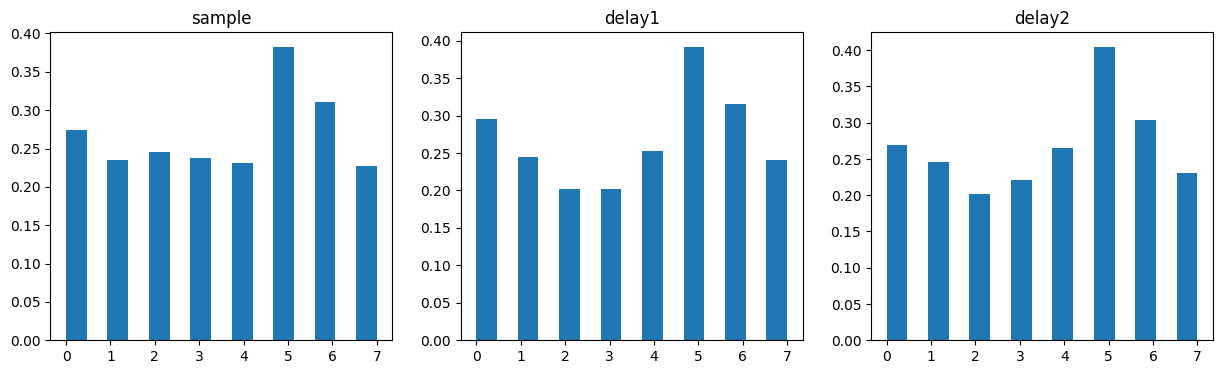

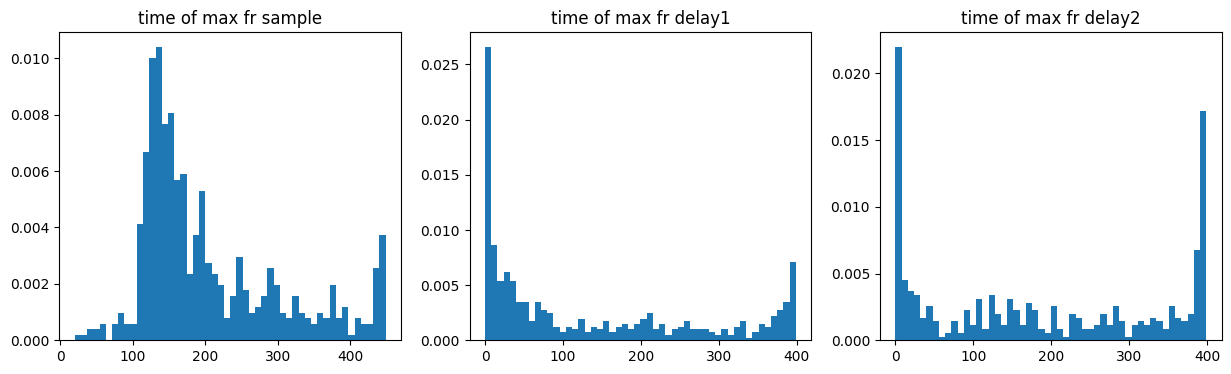

In [87]:
contra_df = df[df['fr_sampleNNin']>df['fr_sampleNNout']]
sresp_contra_df =  contra_df[np.logical_and(contra_df['spmax_bl_ratio_sampleNNin']>=1,contra_df['p_maxfr_sampleNNin']<0.05)]
d1resp_contra_df = contra_df[np.logical_and(contra_df['spmax_bl_ratio_delay1NNin']>=1,contra_df['p_maxfr_sampleNNin']<0.05)]
d2resp_contra_df = contra_df[np.logical_and(contra_df['spmax_bl_ratio_delay2NNin']>=1,contra_df['p_maxfr_sampleNNin']<0.05)]
f,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].hist(sresp_contra_df['ch_row'],density=True,bins=15)
ax[0].set_title('sample')
ax[1].hist(d1resp_contra_df['ch_row'],density=True,bins=15)
ax[1].set_title('delay1')
_=ax[2].hist(d2resp_contra_df['ch_row'],density=True,bins=15)
_=ax[2].set_title('delay2')
f,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].hist(sresp_contra_df['maxfrlat_sampleNNin'],density=True,bins=50)
ax[0].set_title('time of max fr sample')
ax[1].hist(d1resp_contra_df['maxfrlat_delay1NNin'],density=True,bins=50)
ax[1].set_title('time of max fr delay1')
_=ax[2].hist(d2resp_contra_df['maxfrlat_delay2NNin'],density=True,bins=50)
_=ax[2].set_title('time of max fr delay2')

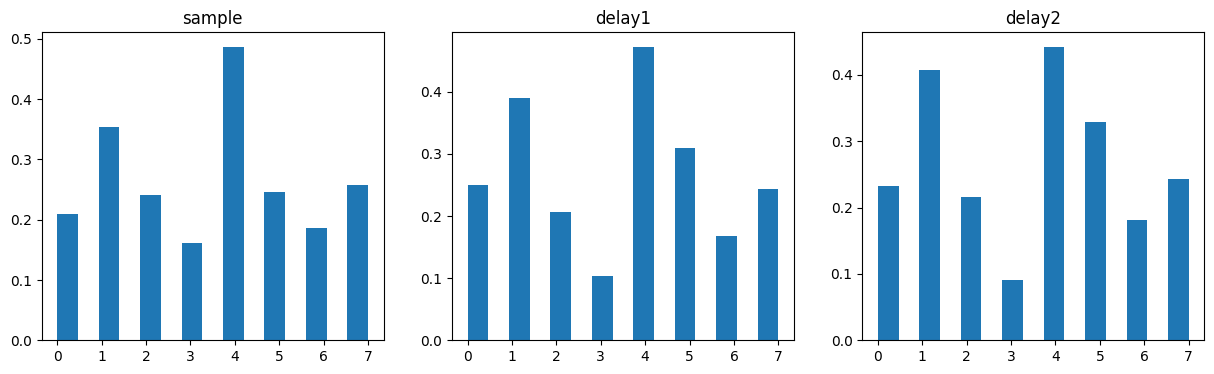

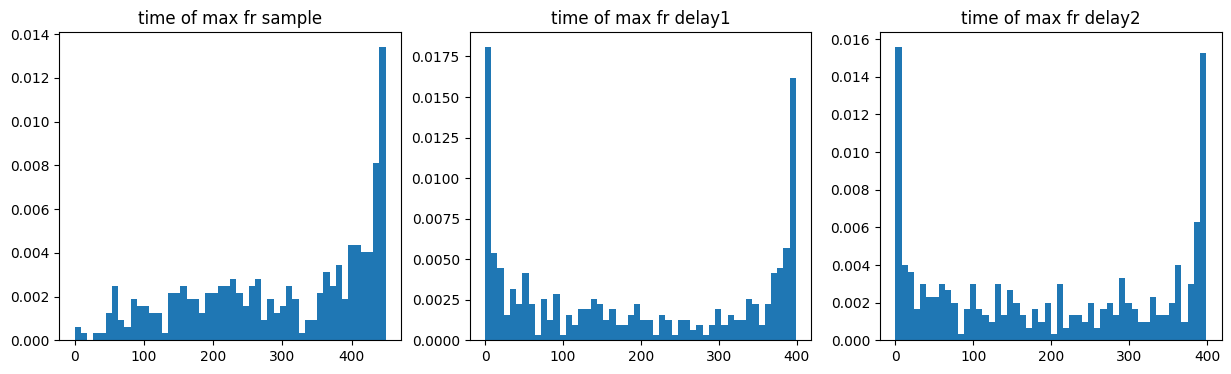

In [88]:
ipsi_df = df[df['fr_sampleNNin']<df['fr_sampleNNout']]
sresp_ipsi_df =  ipsi_df[np.logical_and(ipsi_df['spmax_bl_ratio_sampleNNout']>=1,ipsi_df['p_maxfr_sampleNNout']<0.05)]
d1resp_ipsi_df = ipsi_df[np.logical_and(ipsi_df['spmax_bl_ratio_delay1NNout']>=1,ipsi_df['p_maxfr_sampleNNout']<0.05)]
d2resp_ipsi_df = ipsi_df[np.logical_and(ipsi_df['spmax_bl_ratio_delay2NNout']>=1,ipsi_df['p_maxfr_sampleNNout']<0.05)]
f,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].hist(sresp_ipsi_df['ch_row'],density=True,bins=15)
ax[0].set_title('sample')
ax[1].hist(d1resp_ipsi_df['ch_row'],density=True,bins=15)
ax[1].set_title('delay1')
_=ax[2].hist(d2resp_ipsi_df['ch_row'],density=True,bins=15)
_=ax[2].set_title('delay2')
f,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].hist(sresp_ipsi_df['maxfrlat_sampleNNout'],density=True,bins=50)
ax[0].set_title('time of max fr sample')
ax[1].hist(d1resp_ipsi_df['maxfrlat_delay1NNout'],density=True,bins=50)
ax[1].set_title('time of max fr delay1')
_=ax[2].hist(d2resp_ipsi_df['maxfrlat_delay2NNout'],density=True,bins=50)
_=ax[2].set_title('time of max fr delay2')